# Import Required Libraries

In [1]:
import sys
import os
os.chdir("..")
os.chdir("./src")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import pylab as pl

from BSMBSS import *
from general_utils import *
from visualization_utils import * 

import warnings
warnings.filterwarnings("ignore")

notebook_name = 'Antisparse_Copula'

# Source Generation and Mixing Scenario

In [3]:
rho = 0.0
N = 500000
NumberofSources = 5
NumberofMixtures = 10

SNR = 30 # dB
INPUT_STD = 0.5
S = 2*np.random.uniform(size = (NumberofSources,int(N)))-1
S = ProjectRowstoL1NormBall(S.T).T

A = np.random.standard_normal(size=(NumberofMixtures,NumberofSources))
X = A @ S
for MM in range(A.shape[0]):
    stdx = np.std(X[MM,:])
    A[MM,:] = A[MM,:]/stdx * INPUT_STD
X = A @ S
X, NoisePart = addWGN(X, SNR, return_noise = True)

SNRinp = 10 * np.log10(np.sum(np.mean((X - NoisePart)**2, axis = 1)) / np.sum(np.mean(NoisePart**2, axis = 1)))

print("The following is the mixture matrix A")
display_matrix(A)
print("Input SNR is : {}".format(SNRinp))

The following is the mixture matrix A


<IPython.core.display.Math object>

Input SNR is : 29.997317875378357


# Visualize Generated Sources and Mixtures

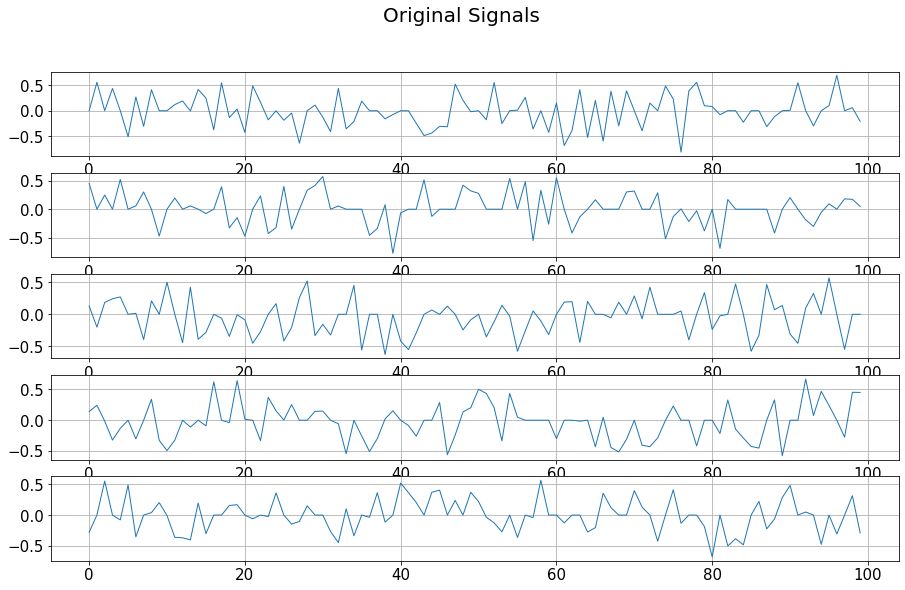

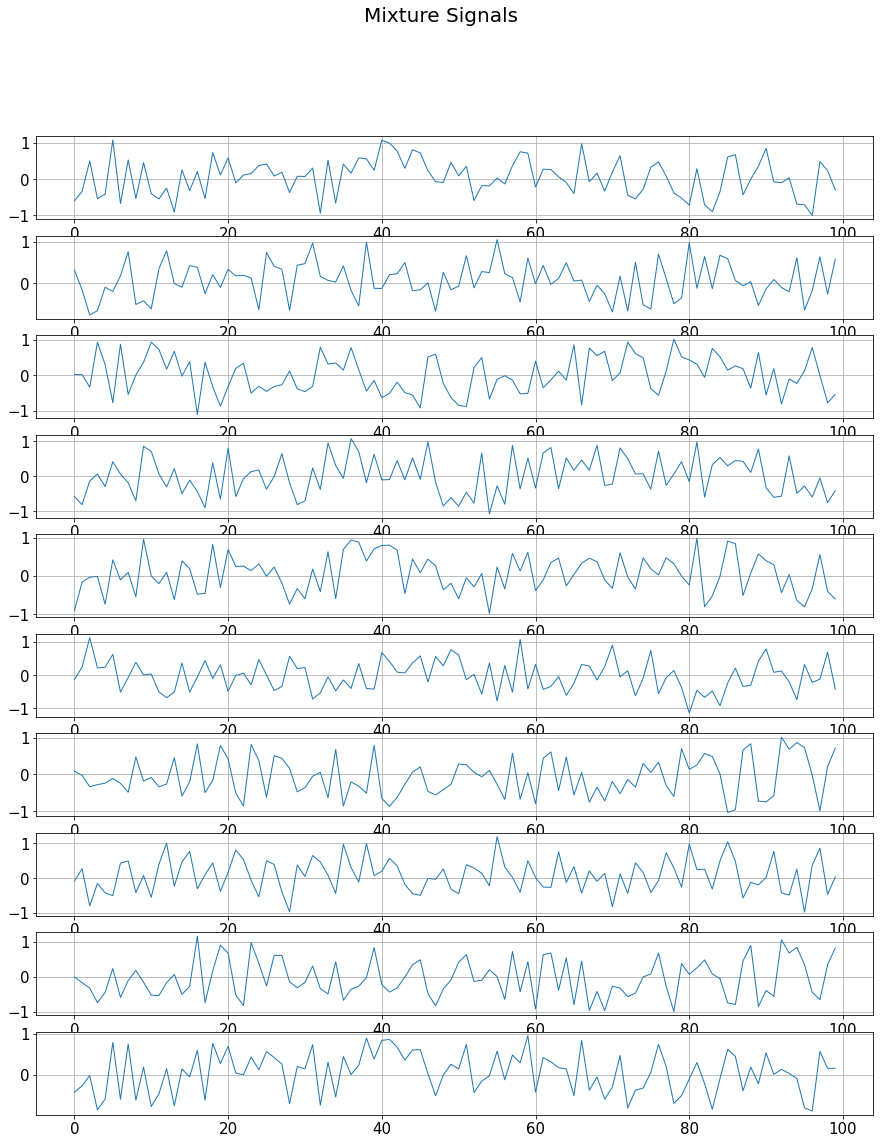

In [4]:
subplot_1D_signals(S[:,0:100], title = 'Original Signals', figsize = (15.2,9), colorcode = None)
subplot_1D_signals(X[:,0:100], title = 'Mixture Signals', figsize = (15,18), colorcode = None)

# Algorithm Hyperparameter Selection and Weight Initialization

In [5]:
debug_iteration_point = 25000
gamma = np.sqrt(1 - 1e-3)
W = np.eye(NumberofSources)
M = 0.1*np.eye(NumberofSources)

# Run BSM Algorithm on Mixture Signals

In [6]:
model = OnlineBSM(s_dim = NumberofSources, x_dim = NumberofMixtures, beta = 1e-6, 
                  gamma = gamma, whiten_input_ = True,
                  W = W, M = M,
                  neural_OUTPUT_COMP_TOL = 1e-7, set_ground_truth = True, S = S, A = A)

model.fit_batch_sparse(X = X, n_epochs = 1, neural_dynamic_iterations = 500,
                         neural_lr_start = 1.5, neural_lr_stop = 0.001, fast_start = True,
                         debug_iteration_point = debug_iteration_point, plot_in_jupyter = True)

  0%|          | 0/500000 [00:07<?, ?it/s]


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
No implementation of function Function(<function outer at 0x2ae347f8c700>) found for signature:
 
 >>> outer(none, array(float64, 1d, A))
 
There are 2 candidate implementations:
   - Of which 2 did not match due to:
   Overload in function 'outer_impl': File: numba/np/linalg.py: Line 2632.
     With argument(s): '(none, array(float64, 1d, A))':
    Rejected as the implementation raised a specific error:
      TypingError: Failed in nopython mode pipeline (step: nopython frontend)
    No implementation of function Function(<function outer_impl_none at 0x2ae3a561d430>) found for signature:
     
     >>> outer_impl_none(none, array(float64, 1d, A), none)
     
    There are 2 candidate implementations:
          - Of which 2 did not match due to:
          Overload in function 'register_jitable.<locals>.wrap.<locals>.ov_wrap': File: numba/core/extending.py: Line 159.
            With argument(s): '(none, array(float64, 1d, A), none)':
           Rejected as the implementation raised a specific error:
             TypingError: Failed in nopython mode pipeline (step: nopython frontend)
           No implementation of function Function(<built-in function asarray>) found for signature:
            
            >>> asarray(none)
            
           There are 2 candidate implementations:
                 - Of which 2 did not match due to:
                 Overload of function 'asarray': File: numba/np/arraymath.py: Line 4285.
                   With argument(s): '(none)':
                  No match.
           
           During: resolving callee type: Function(<built-in function asarray>)
           During: typing of call at /kuacc/users/bbozkurt15/.conda/envs/wsm/lib/python3.8/site-packages/numba/np/linalg.py (2609)
           
           
           File "../../../../../../../kuacc/users/bbozkurt15/.conda/envs/wsm/lib/python3.8/site-packages/numba/np/linalg.py", line 2609:
           def outer_impl_none(a, b, out):
               aa = np.asarray(a)
               ^
    
      raised from /kuacc/users/bbozkurt15/.conda/envs/wsm/lib/python3.8/site-packages/numba/core/typeinfer.py:1086
    
    During: resolving callee type: Function(<function outer_impl_none at 0x2ae3a561d430>)
    During: typing of call at /kuacc/users/bbozkurt15/.conda/envs/wsm/lib/python3.8/site-packages/numba/np/linalg.py (2641)
    
    
    File "../../../../../../../kuacc/users/bbozkurt15/.conda/envs/wsm/lib/python3.8/site-packages/numba/np/linalg.py", line 2641:
        def outer_impl(a, b, out=None):
            return impl(a, b, out)
            ^

  raised from /kuacc/users/bbozkurt15/.conda/envs/wsm/lib/python3.8/site-packages/numba/core/typeinfer.py:1086

During: resolving callee type: Function(<function outer at 0x2ae347f8c700>)
During: typing of call at /scratch/users/bbozkurt15/WSM_BlindSourceSeparation/Biologically-Plausible-DetMaxNNs-for-Blind-Source-Separation/NewVersionDevelopment/src/BSMBSS.py (275)


File "BSMBSS.py", line 275:
    def update_weights_jit(x_current, y, W, M, D, gamma, beta, mu):
        <source elided>
        # Synaptic & Similarity weight updates, follows from equations (12,13,14,15,16) from the paper
        W = (gamma ** 2) * W + (1 - gamma ** 2) * np.outer(y,x_current)
        ^


<Figure size 3600x2400 with 0 Axes>

In [ ]:
model.M.shape

# Calculate Resulting Component SNRs and Overall SINR

In [ ]:
Wf = model.compute_overall_mapping(return_mapping = True)
# Wf = np.linalg.pinv(M * D.T) @ W @ model.Wpre
Y = Wf @ X
Y_ = signed_and_permutation_corrected_sources(S,Y)
coef_ = ((Y_ * S).sum(axis = 1) / (Y_ * Y_).sum(axis = 1)).reshape(-1,1)
Y_ = coef_ * Y_

print("Component SNR Values : {}\n".format(snr_jit(S, Y_)))

SINRwsm = 10*np.log10(CalculateSINRjit(Y_, S)[0])

print("Overall SINR : {}".format(SINRwsm))

# Vizualize Extracted Signals Compared to Original Sources

In [ ]:
subplot_1D_signals(Y_[:,0:100], title = 'Extracted Signals (Sign and Permutation Corrected)', figsize = (15.2,9), colorcode = None)
subplot_1D_signals(S[:,0:100], title = 'Original Signals', figsize = (15.2,9), colorcode = None)